In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/equon')
from windtools.SOWFA6.postProcessing.averaging import PlanarAverages
from windtools.SOWFA6.postProcessing.probes import Probe
from windtools.common import calc_wind, covariance
from mmctools.helper_functions import estimate_ABL_height
from windtools.plotting import plot_timehistory_at_height, plot_profile

# SOWFA postprocessing example
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov), 2020-03-10

dependencies:
- windtools https://github.com/NREL/windtools
- mmctools (dev branch) https://github.com/a2e-mmc/mmctools/tree/dev

In [3]:
casedir = '/projects/car/equon/diurnal_example/run.tency.w0_L0'

In [4]:
starttime = pd.to_datetime('2013-11-08')

In [5]:
tavg_window = '10min' # pandas offset string

## read planar averaged data

In [6]:
%%time
avgdata = PlanarAverages(os.path.join(casedir,'postProcessing','planarAverages'),
                         varList=['U','T','TU','UU'])

# CPU times: user 28 s, sys: 2.99 s, total: 31 s
# Wall time: 32.2 s

Simulation (re)start times: [43200.0, 72000.0]
  read U
  read T
  read TU
  read UU
CPU times: user 30.8 s, sys: 4.16 s, total: 35 s
Wall time: 36.3 s


In [7]:
%time pavg = avgdata.to_pandas()
pavg.head()

# CPU times: user 14.6 s, sys: 1.45 s, total: 16.1 s
# Wall time: 16.1 s

Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
CPU times: user 18.4 s, sys: 1.91 s, total: 20.3 s
Wall time: 20.4 s


Ux        Uy   Uz           T           TUx           TUy  \
t       z                                                                       
43200.0 5.0   1.757663  1.925548  0.0  282.557614 -9.938576e-18  1.097381e-18   
        15.0  2.951346  3.327239  0.0  283.759714  2.837814e-19 -4.458681e-19   
        25.0  3.727699  4.355220  0.0  284.648814 -3.859809e-20  1.751988e-21   
        35.0  4.290016  5.194795  0.0  285.396748  2.402321e-25  6.494075e-26   
        45.0  4.715604  5.917975  0.0  286.081772  1.684613e-25  1.672801e-25   

              TUz      UUxx          UUxy  UUxz      UUyy  UUyz  UUzz  
t       z                                                              
43200.0 5.0   0.0  0.002295 -1.967237e-18   0.0  0.002295   0.0   0.0  
        15.0  0.0  0.016539  7.221388e-19   0.0  0.016539   0.0   0.0  
        25.0  0.0  0.029457  2.373781e-18   0.0  0.029457   0.0   0.0  
        35.0  0.0  0.029643 -1.597073e-18   0.0  0.029643   0.0   0.0  
        45.0  0.0  0.020145  6.430128e-19   0.0  0.020145   0.0   0.0

In [8]:
%%time
# rename to more standard var names and convert to datetime index
#   to compare with probe stats later (optional)
# note: df.rename(index=...) is really slow for some reason 
pavg = pavg.reset_index()
pavg.rename(
    columns={
        't':'datetime','z':'height',
        'Ux':'U', 'Uy':'V', 'Uz':'W',          # mean velocity components <u_i>
        'UUxx':'uu', 'UUyy':'vv', 'UUzz':'ww', # variances <u_i' u_i'>
        'UUxy':'uv', 'UUxz':'uw', 'UUyz':'vw', # covariances <u_i' u_j'>
        'TUx': 'tu', 'TUy':'tv', 'TUz':'tw',   # temperature-velocity covariances, <t' u_i'>
    },
    inplace=True,
)
pavg['datetime'] = starttime + pd.to_timedelta(pavg['datetime'], unit='s')
pavg = pavg.set_index(['datetime','height'])
pavg.head()

# CPU times: user 1.73 s, sys: 1.08 s, total: 2.81 s
# Wall time: 2.81 s

CPU times: user 2.15 s, sys: 1.3 s, total: 3.45 s
Wall time: 3.46 s


U         V    W           T            tu  \
datetime            height                                                      
2013-11-08 12:00:00 5.0     1.757663  1.925548  0.0  282.557614 -9.938576e-18   
                    15.0    2.951346  3.327239  0.0  283.759714  2.837814e-19   
                    25.0    3.727699  4.355220  0.0  284.648814 -3.859809e-20   
                    35.0    4.290016  5.194795  0.0  285.396748  2.402321e-25   
                    45.0    4.715604  5.917975  0.0  286.081772  1.684613e-25   

                                      tv   tw        uu            uv   uw  \
datetime            height                                                   
2013-11-08 12:00:00 5.0     1.097381e-18  0.0  0.002295 -1.967237e-18  0.0   
                    15.0   -4.458681e-19  0.0  0.016539  7.221388e-19  0.0   
                    25.0    1.751988e-21  0.0  0.029457  2.373781e-18  0.0   
                    35.0    6.494075e-26  0.0  0.029643 -1.597073e-18  0.0   
                    45.0    1.672801e-25  0.0  0.020145  6.430128e-19  0.0   

                                  vv   vw   ww  
datetime            height                      
2013-11-08 12:00:00 5.0     0.002295  0.0  0.0  
                    15.0    0.016539  0.0  0.0  
                    25.0    0.029457  0.0  0.0  
                    35.0    0.029643  0.0  0.0  
                    45.0    0.020145  0.0  0.0

## read virtual met mast from probes

In [9]:
%time metdata = Probe(os.path.join(casedir,'postProcessing','probe1'))

# CPU times: user 45.9 s, sys: 4.02 s, total: 49.9 s
# Wall time: 50.7 s

Simulation (re)start times: [43200.0, 72000.0]
  read U
  read T
CPU times: user 51.9 s, sys: 5.58 s, total: 57.4 s
Wall time: 58.5 s


In [10]:
%time met = metdata.to_pandas()
met.head()

# CPU times: user 34.4 s, sys: 4.55 s, total: 39 s
# Wall time: 39.1 s

Creating dataframe for [ 43200.5  43201.   43201.5 ... 129599.  129599.5 129600. ]
CPU times: user 50.5 s, sys: 4.97 s, total: 55.5 s
Wall time: 55.8 s


Ux        Uy        Uz           T
t       z                                               
43200.5 5.001   1.773844  1.928823 -0.000077  282.556471
        15.001  2.998625  3.336528 -0.000442  283.759527
        25.001  3.792664  4.366180 -0.000991  284.648818
        35.001  4.356437  5.204311 -0.001605  285.396775
        45.001  4.771084  5.924402 -0.002198  286.081842

In [11]:
# convert to datetime index for stats analysis
# - also, due to an OpenFOAM sampling quirk, there is a slight offset in the sampling height...
#   let's remove it for simplicity
met = met.reset_index()
met.rename(columns={'t':'datetime', 'z':'height', 'Ux':'u', 'Uy':'v', 'Uz':'w'}, inplace=True)
met['datetime'] = starttime + pd.to_timedelta(met['datetime'], unit='s')
met['height'] = met['height'].round(decimals=2)
met = met.set_index(['datetime','height'])
met.head()

u         v         w           T
datetime                height                                          
2013-11-08 12:00:00.500 5.0     1.773844  1.928823 -0.000077  282.556471
                        15.0    2.998625  3.336528 -0.000442  283.759527
                        25.0    3.792664  4.366180 -0.000991  284.648818
                        35.0    4.356437  5.204311 -0.001605  285.396775
                        45.0    4.771084  5.924402 -0.002198  286.081842

## calculate time statistics

In [12]:
%time met_unstacked = met[['u','v','w','T']].unstack()

# CPU times: user 6.86 s, sys: 2.2 s, total: 9.06 s
# Wall time: 9.09 s

CPU times: user 9.96 s, sys: 1.56 s, total: 11.5 s
Wall time: 11.6 s


In [13]:
tavg = met_unstacked.resample(tavg_window).mean().stack()
tavg.rename(columns={'u':'U', 'v':'V', 'w':'W'}, inplace=True)  # for consistency with pavg

In [14]:
var = met_unstacked[['u','v','w']].resample(tavg_window).var().stack()
tavg['uu'] = var['u']
tavg['vv'] = var['v']
tavg['ww'] = var['w']

In [15]:
%%time
tavg['uv'] = covariance(met['u'], met['v'], interval=tavg_window, resample=True)
tavg['uw'] = covariance(met['u'], met['w'], interval=tavg_window, resample=True)
tavg['vw'] = covariance(met['v'], met['w'], interval=tavg_window, resample=True)
tavg['tw'] = covariance(met['T'], met['w'], interval=tavg_window, resample=True)

# CPU times: user 37.7 s, sys: 9.9 s, total: 47.6 s
# Wall time: 47.7 s

CPU times: user 1min 12s, sys: 6.67 s, total: 1min 19s
Wall time: 1min 19s


In [16]:
tavg.head()

U         V         W           T  \
datetime            height                                             
2013-11-08 12:00:00 5.0     1.206649  1.337266  0.001408  281.751692   
                    15.0    3.031902  3.508746 -0.000331  283.837207   
                    25.0    3.767883  4.446121 -0.000129  284.679567   
                    35.0    4.300829  5.193674 -0.001931  285.385529   
                    45.0    4.768966  6.020331 -0.001869  286.034527   

                                  uu        vv        ww        uv        uw  \
datetime            height                                                     
2013-11-08 12:00:00 5.0     0.073205  0.059779  0.000328  0.063821 -0.000250   
                    15.0    0.018269  0.029163  0.000189  0.003624 -0.000188   
                    25.0    0.020723  0.030638  0.000486 -0.001322 -0.000230   
                    35.0    0.021859  0.038272  0.000887  0.005715 -0.000378   
                    45.0    0.019119  0.026871  0.001060  0.004976 -0.000003   

                                  vw        tw  
datetime            height                      
2013-11-08 12:00:00 5.0    -0.000225 -0.000172  
                    15.0   -0.000468  0.000413  
                    25.0    0.000651 -0.000722  
                    35.0   -0.000977 -0.000400  
                    45.0   -0.000170 -0.000375

## calculate other quantities of interest

In [17]:
def estimate_diurnal_ABL_height(df,thresh0=100.0,median_window='30min'):
    """
    df: dataframe with datetime/height multiindices
    thresh0: value below which the CBL is considered "0" height, i.e., the SBL should be used
    median_window: for denoising
    """
    # convective boundary layer
    cblh = estimate_ABL_height(Tw=pavg['tw'])
    cblh = cblh.rolling(median_window).median()
    # stable boundary layer
    sblh = estimate_ABL_height(uw=np.sqrt(df['uw']**2 + df['vw']**2))
    sblh = sblh.rolling(median_window).median()
    # blend
    ablh = cblh.copy()
    isstable = (cblh < thresh0)
    ablh.loc[isstable] = sblh.loc[isstable]
    return ablh

In [18]:
def calculate_MOL(ts,k=0.4,g=9.81):
    """Calculate the Monin-Obukhov Length, a measure of atmospheric stability
    ts: timeseries dataframe with datetime index
    k: von Karman constant
    g: gravitational acceleration
    """
    tw_no0 = ts['tw'].copy()
    tw_no0.loc[tw_no0==0] = np.nan
    #return -ts['u*']**3 * ts['T'] / (k*g*ts['tw'])
    # avoid ZeroDivision error
    return -ts['u*']**3 * ts['T'] / (k*g*tw_no0)

In [19]:
def calculate_wstar(ts,g=9.81):
    """Calculate convective updraft velocity
    ts: timeseries dataframe with datetime index
    """
    isunstable = (ts['tw'] >= 0)
    wstar = np.empty(len(ts))
    uns = ts.loc[isunstable,:]
    wstar = (g * uns['zi'] / uns['T'] * uns['tw'])**(1./3.)
    assert np.count_nonzero(np.imag(wstar)) == 0
    return wstar

In [20]:
def calc_QOIs(df,zref=10.0):
    """
    Update dataframes in place
    """
    df['wspd'],df['wdir'] = calc_wind(u=df['U'],v=df['V'])
    
    # turbulence statistics
    df['TKE'] = 0.5*(df['uu'] + df['vv'] + df['ww'])
    windangle = np.radians(270.0 - df['wdir'])
    df['TI'] = np.sqrt(df['uu'] * np.cos(windangle)**2 \
                     + df['uv'] * 2*np.sin(windangle)*np.cos(windangle) \
                     + df['vv'] * np.sin(windangle)**2) / df['wspd']
    df['u*'] = (df['uw']**2 + df['vw']**2)**0.25
    
    # approximate quantities
    try:
        # get timeseries at reference height
        ts = df.xs(zref, level='height')
    except KeyError:
        from scipy.interpolate import interp1d
        tmp = df.unstack(level='datetime')
        print('interpolate near-surface z=',zref)
        tmp.loc[zref] = interp1d(tmp.index, tmp, axis=0)(zref)
        ts = tmp.loc[zref].reorder_levels([1,0]).unstack()
    ts['zi'] = estimate_diurnal_ABL_height(df)
    ts['z/L'] = zref / calculate_MOL(ts)
    ts['w*'] = calculate_wstar(ts)
    
    return ts
    
%time ts_pavg = calc_QOIs(pavg)
%time ts_tavg = calc_QOIs(tavg)

interpolate near-surface z= 10.0
CPU times: user 1min 13s, sys: 3.55 s, total: 1min 17s
Wall time: 1min 17s
interpolate near-surface z= 10.0
CPU times: user 2.24 s, sys: 27.9 ms, total: 2.27 s
Wall time: 2.28 s


## plots

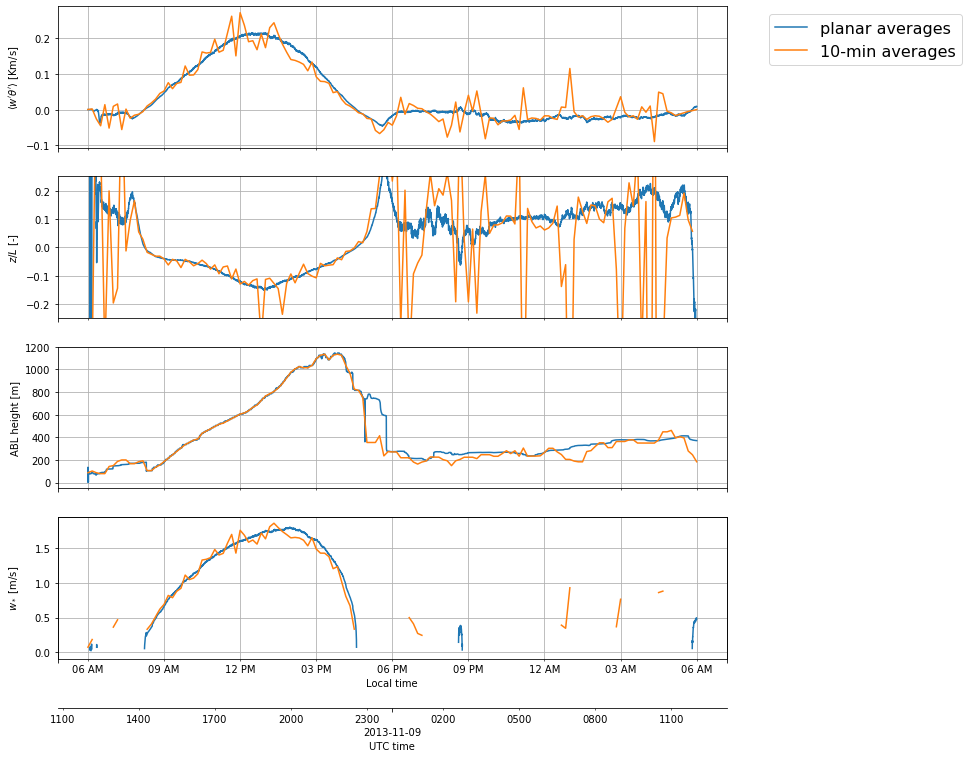

In [21]:
fig,ax,timeax = plot_timehistory_at_height(
    datasets={
        'planar averages': ts_pavg,
        '10-min averages': ts_tavg,
    },
    fields=['tw','z/L','zi','w*'],
    fieldlabels={
        'z/L':'$z/L$ [-]',
        'zi': 'ABL height [m]',
        'w*': '$w_*$ [m/s]',
    },
    fieldlimits={'z/L':(-0.25,0.25)},
    plot_local_time=True, local_time_offset=-6,
)

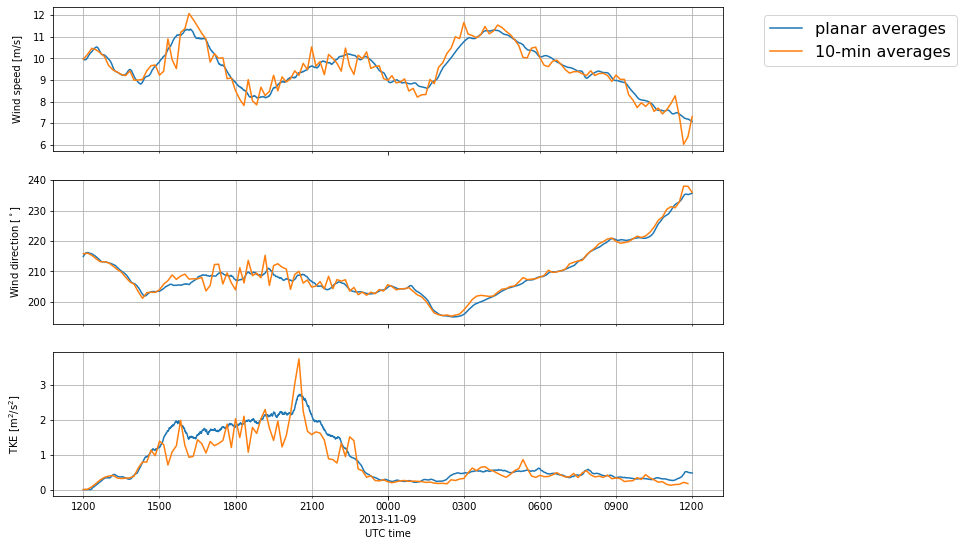

In [22]:
#
# hub-height timehistories
#
fig,ax = plot_timehistory_at_height(
    datasets={
        'planar averages': pavg,
        '10-min averages': tavg,
    },
    heights=80,
    fields=['wspd','wdir','TKE'],
    stack_by_datasets=True,
)

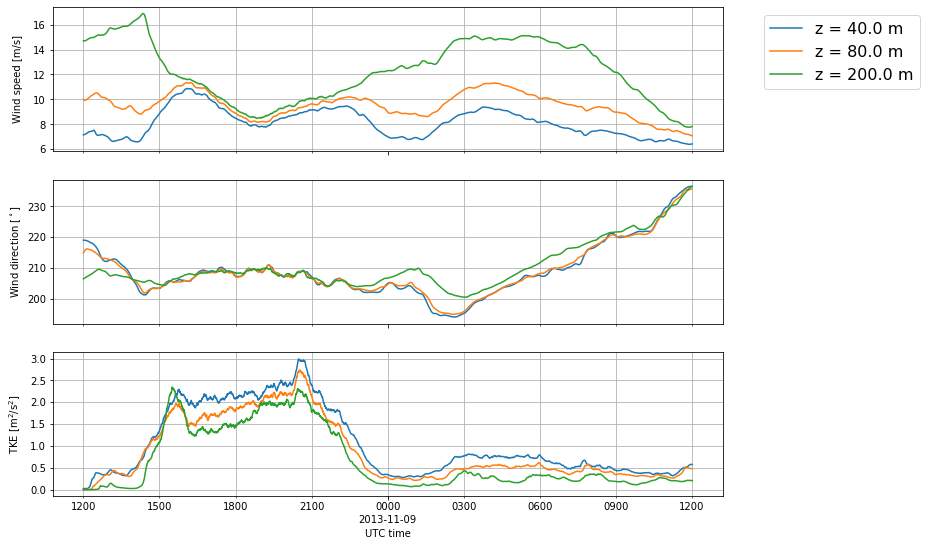

In [23]:
#
# planar average time histories at various heights
#
fig,ax = plot_timehistory_at_height(
    datasets=pavg,
    heights=[40,80,200],
    fields=['wspd','wdir','TKE'],
)

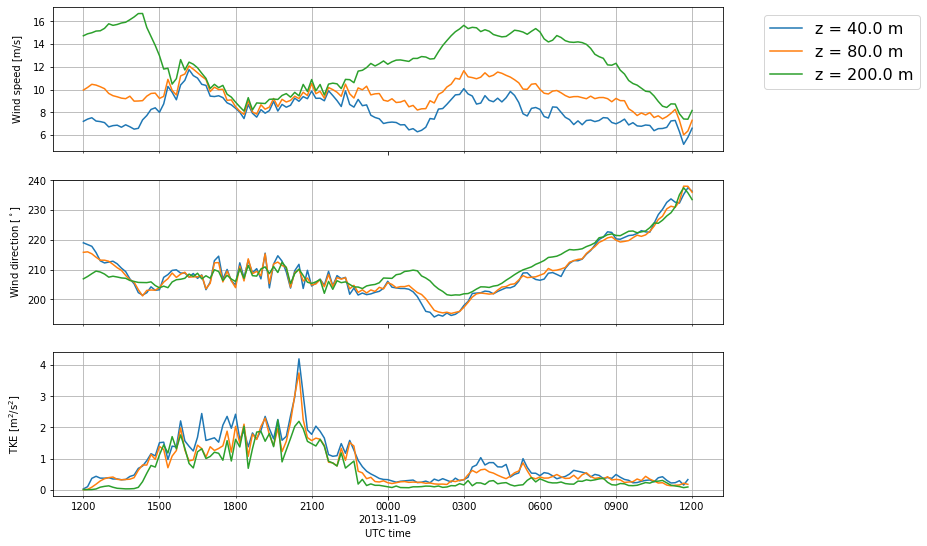

In [24]:
#
# temporal average time histories at various heights
#
fig,ax = plot_timehistory_at_height(
    datasets=tavg,
    heights=[40,80,200],
    fields=['wspd','wdir','TKE'],
)

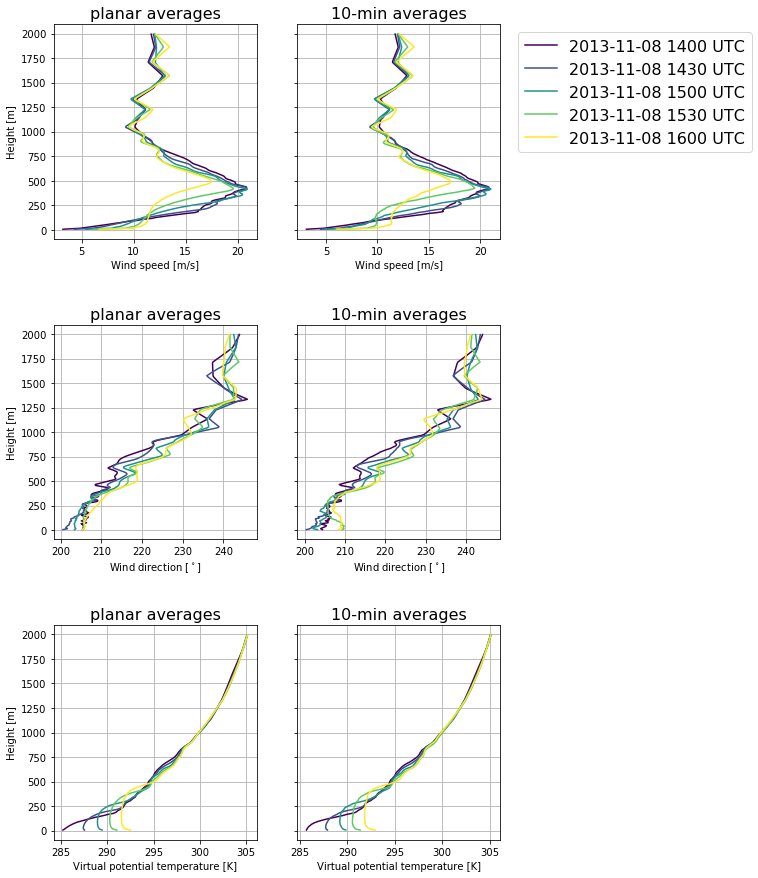

In [25]:
#
# morning transition profiles
#
selectedtimes = pd.date_range('2013-11-08 14:00','2013-11-08 16:00',freq='30min')
fig,ax = plot_profile(
    datasets={
        'planar averages': pavg,
        '10-min averages': tavg,
    },
    fields=['wspd','wdir','T'],
    fieldlabels={'T':'Virtual potential temperature [K]'},
    times=selectedtimes,
    cmap='viridis',
)

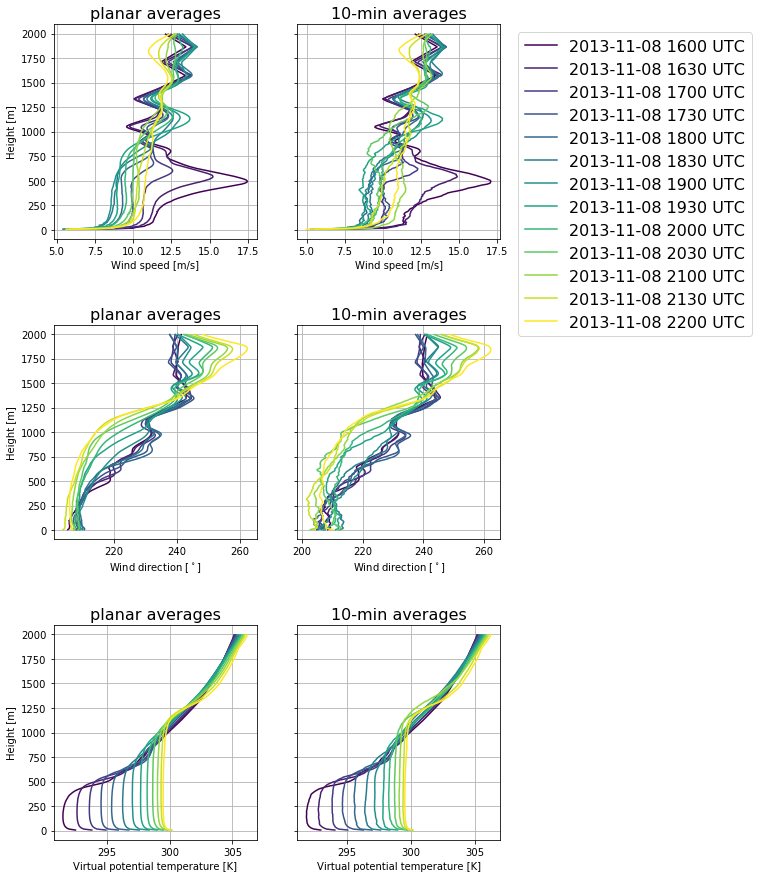

In [26]:
#
# daytime profiles
#
selectedtimes = pd.date_range('2013-11-08 16:00','2013-11-08 22:00',freq='30min')
fig,ax = plot_profile(
    datasets={
        'planar averages': pavg,
        '10-min averages': tavg,
    },
    fields=['wspd','wdir','T'],
    fieldlabels={'T':'Virtual potential temperature [K]'},
    times=selectedtimes,
    cmap='viridis',
)

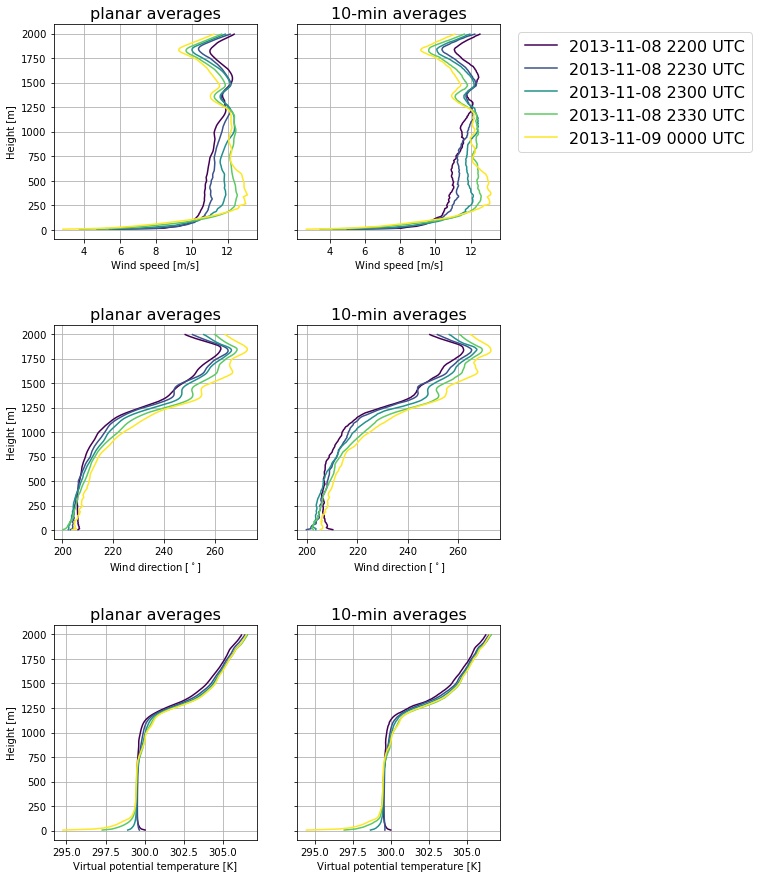

In [27]:
#
# evening transition
#
selectedtimes = pd.date_range('2013-11-08 22:00','2013-11-09 00:00',freq='30min')
fig,ax = plot_profile(
    datasets={
        'planar averages': pavg,
        '10-min averages': tavg,
    },
    fields=['wspd','wdir','T'],
    fieldlabels={'T':'Virtual potential temperature [K]'},
    times=selectedtimes,
    cmap='viridis',
)